In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_fscore_support
)
import math
import os
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Loading the dataset 

In [2]:
df = pd.read_csv("transactions.csv")

# STEP 2:  DATA PREPROCESSING


2.1 first we sort the dataset according to chronology i.e. we sort it based on time as anomalies are computed strictly from past data and prevent leak of future during the train test split 

In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df = df.sort_values("timestamp").reset_index(drop=True)

2.2 now we drop rows and columns based on the following- 
 - if amount<0
 - if hour is not present in [0,23] 
 - day_of_the_week must be present between [0,6] if not we drop
 - if month is not present between [1,12]
 - duplicates
 - we drop any unique value identifier columns as they don't carry predictive pattern information

In [4]:
df = df[df["amount"] > 0]
df = df[(df["hour"] >= 0) & (df["hour"] <= 23)]
df = df[(df["day_of_week"] >= 0) & (df["day_of_week"] <= 6)]
df = df[(df["month"] >= 1) & (df["month"] <= 12)]
df = df.drop_duplicates()
y = df["is_fraud"].astype(int).reset_index(drop=True)
drop_cols = ["transaction_id","card_number","customer_id","merchant_id","timestamp","fraud_type"]
df = df.drop(columns=drop_cols)

# ITERATION 4: PROBLEM IDENTIFIED: Label leakage 

In [5]:
# 1) Are we accidentally leaving 'is_fraud' in the features?
print("'is_fraud' in df columns?", 'is_fraud' in df.columns)

'is_fraud' in df columns? True


In [6]:
df

,amount,merchant_category,merchant_lat,merchant_long,is_fraud,hour,day_of_week,month,distance_from_home
0,22779.74,jewelry,19.128865,72.902100,0,0,2,1,847.23
1,62609.57,electronics,19.009754,72.828282,0,0,2,1,1036.73
2,2155.20,gas,12.934345,77.606382,0,0,2,1,1566.57
3,344.87,grocery,28.705806,77.098609,0,0,2,1,1752.77
4,1271.03,restaurant,12.970154,77.615085,0,0,2,1,840.52
...,...,...,...,...,...,...,...,...,...
99995,13909.13,jewelry,28.652728,77.127274,0,23,6,3,1765.79
99996,23845.01,luxury_goods,13.041175,80.205535,0,23,6,3,1771.48
99997,1744.53,grocery,19.083755,72.912571,0,23,6,3,862.94
99998,1346.82,restaurant,19.053875,72.884754,0,23,6,3,5.72


2.3 Feature Engineering

- Since time is cricular i.e. 23hours is not far away from 0 hours so cyclical encoding using sine and cosine transformations is applied to preserve circular geometry rather than linear 

In [7]:
def cyclical(col, max_val):
    return (
        np.sin(2*np.pi*df[col]/max_val),
        np.cos(2*np.pi*df[col]/max_val)
    )

df["hour_sin"], df["hour_cos"] = cyclical("hour", 24)
df["day_sin"], df["day_cos"] = cyclical("day_of_week", 7)
df["month_sin"], df["month_cos"] = cyclical("month", 12)

df = df.drop(columns=["hour","day_of_week","month"])


In [8]:
df 

,amount,merchant_category,merchant_lat,merchant_long,is_fraud,distance_from_home,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,22779.74,jewelry,19.128865,72.902100,0,847.23,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
1,62609.57,electronics,19.009754,72.828282,0,1036.73,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
2,2155.20,gas,12.934345,77.606382,0,1566.57,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
3,344.87,grocery,28.705806,77.098609,0,1752.77,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
4,1271.03,restaurant,12.970154,77.615085,0,840.52,0.000000,1.000000,0.974928,-0.222521,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,13909.13,jewelry,28.652728,77.127274,0,1765.79,-0.258819,0.965926,-0.781831,0.623490,1.0,6.123234e-17
99996,23845.01,luxury_goods,13.041175,80.205535,0,1771.48,-0.258819,0.965926,-0.781831,0.623490,1.0,6.123234e-17
99997,1744.53,grocery,19.083755,72.912571,0,862.94,-0.258819,0.965926,-0.781831,0.623490,1.0,6.123234e-17
99998,1346.82,restaurant,19.053875,72.884754,0,5.72,-0.258819,0.965926,-0.781831,0.623490,1.0,6.123234e-17


- We apply log1p to amount and distance because anomaly models are distance-based without compression, extreme values dominate the geometry and the model collapses into a magnitude detector.

In [9]:
df["amount_log"] = np.log1p(df["amount"])
df["distance_log"] = np.log1p(df["distance_from_home"])

df = df.drop(columns=["amount","distance_from_home"])

2.4 CATEGORICAL ENCODING
- We one-hot encode merchant categories

In [10]:

if "merchant_category" in df.columns:
    df = pd.get_dummies(df, columns=["merchant_category"], drop_first=True)
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

- we drop any non-numeric columns because anomaly models operate purely in numeric geometry.

In [11]:
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print("Dropping non-numeric columns (unexpected):", non_numeric)
    df = df.drop(columns=non_numeric)

# STEP 3: Train Test Split
We perform a time-based 80% train, 20% test split because fraud detection models must learn from the past and predict the future. random splits would leak future fraud patterns and affect performance.

In [12]:
X_df = df.reset_index(drop=True)
y = y.reset_index(drop=True)

n = len(X_df)
split_idx = int(math.floor(n * 0.8))
X_train_df = X_df.iloc[:split_idx].reset_index(drop=True)
X_test_df = X_df.iloc[split_idx:].reset_index(drop=True)
y_train = y.iloc[:split_idx].reset_index(drop=True)
y_test = y.iloc[split_idx:].reset_index(drop=True)


# STEP 4 : Data Normalization 
All numerical features are scaled using RobustScaler, which normalizes data based on median and interquartile range to reduce sensitivity to extreme outliers common in fraud datasets.

In [13]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_df.values)
X_test_scaled = scaler.transform(X_test_df.values)

X_train = pd.DataFrame(X_train_scaled, columns=X_train_df.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_df.columns)

We remove the fraud samples to train autoencoders becuase Autoencoders must be trained only on normal data so they learn the normal manifold

In [14]:
X_train_ae = X_train[y_train == 0].values
X_test_ae = X_test.values

# STEP 5: Training Isolation Forest
Isolation Forest detects fraud by isolating rare behavior using random feature splits, and we set contamination to the known fraud rate to calibrate the anomaly threshold.

In [15]:
SEED = 42
FRAUD_RATE = 0.02  
iso_clf = IsolationForest(
    n_estimators=200,
    contamination=FRAUD_RATE, 
    random_state=SEED,
    n_jobs=-1
)

iso_clf.fit(X_train) 

IsolationForest(contamination=0.02, n_estimators=200, n_jobs=-1,
                random_state=42)

# ITERATION 2 
- we remove the fraud samples (see DECISION_LOG.md)

In [16]:
X_train_normal = X_train[y_train == 0]

print(f"OC-SVM training samples (normal only): {X_train_normal.shape}")

OC-SVM training samples (normal only): (78397, 17)


# Model2: Training One class SVM

In [17]:
ocsvm = OneClassSVM(
    kernel="rbf",      
    nu=FRAUD_RATE,     
    gamma="scale"      
)

ocsvm.fit(X_train_normal)


OneClassSVM(nu=0.02)

# Model3: Autoencoder Architecture
An undercomplete autoencoder is used to learn a compact representation of normal transaction behavior by compressing the input features into a low-dimensional latent space and reconstructing them using a symmetric decoder. The model is trained with mean squared error loss so that fraudulent transactions, which deviate from the learned normal manifold, produce higher reconstruction errors and can be detected as anomalies.


# ITERATION 3: Added another dense 128 unit layer
- REMOVED THE IRRELEVANT dense 128 layer 

In [18]:
input_dim = X_train_ae.shape[1]

input_layer = Input(shape=(input_dim,))

# Encoder
x = Dense(64, activation="relu")(input_layer)
x = Dense(32, activation="relu")(x)
latent = Dense(16, activation="relu")(x)

# Decoder
x = Dense(32, activation="relu")(latent)
x = Dense(64, activation="relu")(x)
output_layer = Dense(input_dim, activation="linear")(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,521 (29.38 KB)

 Trainable params: 7,521 (29.38 KB)

 Non-trainable params: 0 (0.00 B)


# ITERATION3: Autoencoder Training with Early Stopping

- The autoencoder is trained only on legitimate transactions using reconstruction loss, with a validation split to monitor generalization performance. Early stopping is applied to halt training when validation loss stops improving, preventing overfitting and restoring the best-performing model weights.

In [19]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


history = autoencoder.fit(
    X_train_ae,
    X_train_ae,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1684 - val_loss: 0.0258
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7177e-04 - val_loss: 0.0013
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3449e-04 - val_loss: 9.5057e-04
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6133e-04 - val_loss: 7.1883e-04
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8748e-04 - val_loss: 5.1161e-04
Epoch 9/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3574e-04 - val_loss: 3.8846e-04
Epoch 10/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2426e-04 - val_loss: 5.6208e-04
Epoch 11/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7595e-05 - val_loss: 2.5675e-04


In [20]:
X_test_pred = autoencoder.predict(X_test_ae)
recon_error = np.mean(np.square(X_test_ae - X_test_pred), axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


# STEP 6: predictions and confusion matrix

Isolation forest metrics

In [21]:
pred_raw = iso_clf.predict(X_test)
y_pred = (pred_raw == -1).astype(int) 

anomaly_score = -iso_clf.decision_function(X_test)

print("\nConfusion Matrix (test):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=4))

prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
print(f"\nPrecision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")



Confusion Matrix (test):
[[19003   600]
 [   64   333]]

Classification report (test):
              precision    recall  f1-score   support

           0     0.9966    0.9694    0.9828     19603
           1     0.3569    0.8388    0.5008       397

    accuracy                         0.9668     20000
   macro avg     0.6768    0.9041    0.7418     20000
weighted avg     0.9839    0.9668    0.9733     20000


Precision: 0.3569, Recall: 0.8388, F1: 0.5008


One class SVM metrics

In [22]:
# Predictions
ocsvm_raw = ocsvm.predict(X_test)
ocsvm_pred = (ocsvm_raw == -1).astype(int)

ocsvm_scores = -ocsvm.decision_function(X_test)

print("\nOne-Class SVM Confusion Matrix:")
print(confusion_matrix(y_test, ocsvm_pred))

print("\nOne-Class SVM Classification Report:")
print(classification_report(y_test, ocsvm_pred, digits=4))
prec, recall, f1, _ = precision_recall_fscore_support(y_test, ocsvm_pred, average="binary", zero_division=0)
print(f"\nPrecision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")



One-Class SVM Confusion Matrix:
[[18590  1013]
 [   49   348]]

One-Class SVM Classification Report:
              precision    recall  f1-score   support

           0     0.9974    0.9483    0.9722     19603
           1     0.2557    0.8766    0.3959       397

    accuracy                         0.9469     20000
   macro avg     0.6265    0.9124    0.6841     20000
weighted avg     0.9826    0.9469    0.9608     20000


Precision: 0.2557, Recall: 0.8766, F1: 0.3959


In [23]:
# Compute train-normal recon errors once (used to set threshold)
train_pred = autoencoder.predict(X_train_ae)
recon_train = np.mean(np.square(X_train_ae - train_pred), axis=1)

# Choose threshold from training normals (no test peeking)
thr = np.percentile(recon_train, 100 * (1 - FRAUD_RATE))
ae_pred = (recon_error > thr).astype(int)

print(f"AE threshold (train-based) = {thr:.6e}")
print("Train-normal recon_error: mean, std =", recon_train.mean(), recon_train.std())

2450/2450 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step
AE threshold (train-based) = 9.087952e-05
Train-normal recon_error: mean, std = 1.9440366064699234e-05 8.730586962183085e-05


Metrics for AutoEncoders

In [24]:
print("\nAutoencoder Confusion Matrix:")
print(confusion_matrix(y_test, ae_pred))

print("\nAutoencoder Classification Report:")
print(classification_report(y_test, ae_pred, digits=4))
prec, recall, f1, _ = precision_recall_fscore_support(y_test, ae_pred, average="binary", zero_division=0)
print(f"\nPrecision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


Autoencoder Confusion Matrix:
[[16931  2672]
 [    0   397]]

Autoencoder Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8637    0.9269     19603
           1     0.1294    1.0000    0.2291       397

    accuracy                         0.8664     20000
   macro avg     0.5647    0.9318    0.5780     20000
weighted avg     0.9827    0.8664    0.9130     20000


Precision: 0.1294, Recall: 1.0000, F1: 0.2291


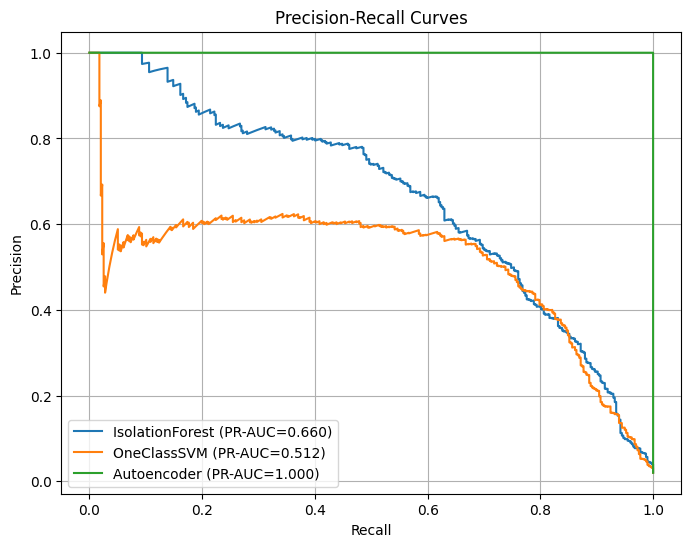

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

scores_map = {
    "IsolationForest": anomaly_score,
    "OneClassSVM": ocsvm_scores,
    "Autoencoder": recon_error
}

plt.figure(figsize=(8,6))
for name, scores in scores_map.items():
    p, r, _ = precision_recall_curve(y_test, scores)
    pr_auc = auc(r, p)
    plt.plot(r, p, label=f"{name} (PR-AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

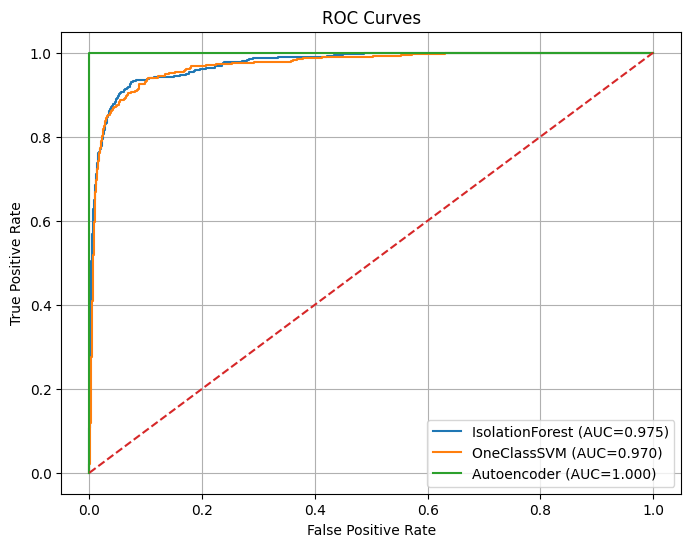

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for name, scores in scores_map.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle='--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
